In [1]:
import csv
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import time
from datetime import datetime
from neo4j import GraphDatabase
import json
import openai
import pandas as pd
import torch
from torch_geometric.data import Data
import re
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

In [2]:
# DeepSeek Api设置
DEEPSEEK_API_KEY = "sk-c886ee978dec45bfa1f184d64cddbc78"
DEEPSEEK_BASE_URL = "https://api.deepseek.com/v1"

# Neo4j配置
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "20040725"

In [3]:
# 爬虫
class NewsSpider:
    def __init__(self):
        self.session = requests.Session()
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
            'Accept-Language': 'en-US,en;q=0.5'
        }
    
    def fetch_page(self, url, timeout=10):
        """通用页面获取方法"""
        try:
            response = self.session.get(url, headers=self.headers, timeout=timeout)
            response.encoding = 'utf-8'
            response.raise_for_status()
            return response.text
        except requests.exceptions.RequestException as e:
            print(f"请求失败 {url}: {str(e)}")
            return None

    def parse_content(self, html):
        """从详情页HTML中提取正文内容"""
        soup = BeautifulSoup(html, 'html.parser')
        content_container = soup.find('div', class_='m-b-10')
        return content_container.get_text(strip=True) if content_container else None

    def crawl_news_list(self, base_url='http://www.cls.cn'):
        """
        核心爬虫方法：获取新闻排行榜数据
        返回结构: [
            {
                'rank': 排名序号,
                'title': 新闻标题,
                'url': 完整链接,
                'content': 新闻正文
            }
        ]
        """
        print(f"开始抓取 {base_url} 的新闻排行榜...")
        html = self.fetch_page(base_url, timeout=15)
        if not html:
            return []

        soup = BeautifulSoup(html, 'html.parser')
        results = []
        
        # 定位排行榜容器
        ranking_container = soup.find('div', class_='home-article-ranking-box')
        if not ranking_container:
            print("未找到排行榜容器")
            return results

        # 提取每条新闻
        news_items = ranking_container.find_all('div', class_='b-c-e6e7ea clearfix home-article-ranking-list')
        print(f"共发现 {len(news_items)} 条新闻")

        for index, item in enumerate(news_items, 1):
            # 提取标题和相对链接
            title_tag = item.find('div', class_='f-l home-article-ranking-title')
            if not (title_tag and title_tag.find('a')):
                continue

            title = title_tag.find('a').text.strip()
            relative_url = title_tag.find('a')['href']
            absolute_url = urljoin(base_url, relative_url)

            # 获取新闻详情
            print(f"正在处理第 {index} 条: {title}")
            detail_html = self.fetch_page(absolute_url)
            content = self.parse_content(detail_html) if detail_html else None

            results.append({
                'rank': index,
                'title': title,
                'url': absolute_url,
                'content': content
            })

            # 礼貌性延迟
            time.sleep(0.5)

        print("抓取完成！")
        return results

In [5]:
class EntityExtractor:
    def __init__(self):
        self.client = openai.OpenAI(
            api_key=DEEPSEEK_API_KEY,
            base_url=DEEPSEEK_BASE_URL
        )
        
        # 缓存已生成的属性模板
        self.property_templates = {}
        
        # 通用属性模板
        self.common_property_templates = {
            "default": ["描述", "重要性", "相关上下文"],
            "人物": ["职位", "所属组织", "行业", "国籍"],
            "组织": ["行业", "所在地", "成立时间", "规模"],
            "地点": ["国家", "省份", "人口", "地理特征"],
            "时间": ["具体日期", "时间段", "季节", "年份"],
            "事件": ["发生时间", "发生地点", "参与方", "影响范围"],
            "产品": ["类型", "制造商", "价格", "功能"]
        }

    # 初始提取
    def extract_entities(self, text):
        if not text:
            print("警告: 输入文本为空，返回空结果")
            return {"entities": [], "relations": []}
    
        print("\n===== 开始实体关系提取 =====")
        print(f"输入文本长度: {len(text)} 字符")
        print(f"文本预览: {text[:100]}...")
    
        try:
            # 第一步：提取实体和关系（包含基本属性）
            response = self.client.chat.completions.create(
                model="deepseek-chat",
                messages=[
                    {
                        "role": "system",
                        "content": """你是一个专业的实体关系提取器。请从文本中提取以下内容：
                        1. 实体（人物、组织、地点、时间等）及类型
                        2. 实体间的关系
                        3. 每个实体的基本属性（尽可能从文本中提取）
                        
                        输出格式必须严格如下：
                        {
                            "entities": [
                                {
                                    "name": "实体名称", 
                                    "type": "实体类型",
                                    "properties": {
                                        "属性1": "值1",
                                        "属性2": "值2",
                                        ...
                                    }
                                },
                                ...
                            ],
                            "relations": [
                                {"from": "实体1", "to": "实体2", "relation": "关系类型"},
                                ...
                            ]
                        }
                        请确保properties中的属性是从文本中直接提取的。
                        只返回JSON格式结果，不要包含任何额外文本。"""
                    },
                    {
                        "role": "user",
                        "content": f"请从以下文本中提取实体和关系：\n{text[:5000]}"
                    }
                ],
                response_format={"type": "json_object"},
                temperature=0.3
            )
            
            # 解析响应
            content = response.choices[0].message.content
            print("\n原始API响应内容:")
            print(content[:500] + "..." if len(content) > 500 else content)
        
            result = json.loads(content) if isinstance(content, str) else content
            
            # 验证结果结构
            if not isinstance(result, dict):
                raise ValueError("返回结果不是字典格式")
            
            # 确保每个实体都有properties字段
            for entity in result.get("entities", []):
                if "properties" not in entity:
                    entity["properties"] = {}
            
            # 统计信息
            print("\n===== 提取结果统计 =====")
            print(f"提取到实体数量: {len(result.get('entities', []))}")
            print(f"提取到关系数量: {len(result.get('relations', []))}")
            
            # 打印示例
            if result.get("entities"):
                print("\n实体示例:")
                for i, entity in enumerate(result["entities"][:3]):
                    props = entity.get("properties", {})
                    prop_str = ", ".join(f"{k}={v}" for k, v in props.items()) if props else "无属性"
                    print(f"{i+1}. {entity.get('name', '无名')} ({entity.get('type', '无类型')}) 属性: {prop_str}")
            
            return result
            
        except Exception as e:
            print(f"\n提取过程中发生错误: {str(e)}")
            import traceback
            traceback.print_exc()
            return {"entities": [], "relations": []}

    def generate_property_templates(self, all_entity_types):
        """为所有实体类型生成属性模板"""
        print("\n===== 开始生成属性模板 =====")
        print(f"需要生成模板的实体类型: {all_entity_types}")
        
        # 过滤掉已经缓存过的类型，只为新出现的实体类型生成模板，同时避免重复生成已知类型的模板
        new_types = [t for t in all_entity_types if t not in self.property_templates]
        if not new_types:
            print("所有类型已有模板，跳过生成")
            return
        
        try:
            # 批量生成属性模板
            response = self.client.chat.completions.create(
                model="deepseek-chat",
                messages=[
                    {
                        "role": "system",
                        "content": """你是一个专业的知识建模专家。请为以下实体类型生成3-5个最相关的属性模板：
                        
                        输出格式必须严格如下：
                        {
                            "templates": {
                                "类型1": ["属性1", "属性2", ...],
                                "类型2": ["属性1", "属性2", ...],
                                ...
                            }
                        }
                        请确保属性是通用、可提取的，避免过于具体的属性。
                        只返回JSON格式结果，不要包含任何额外文本。"""
                    },
                    {
                        "role": "user",
                        "content": f"请为以下实体类型生成属性模板：\n{', '.join(new_types)}"
                    }
                ],
                response_format={"type": "json_object"},
                temperature=0.2
            )
            
            content = response.choices[0].message.content
            templates = json.loads(content)["templates"]
            
            # 更新缓存
            self.property_templates.update(templates)
            print("生成的属性模板:")
            for t, props in templates.items():
                print(f"- {t}: {', '.join(props)}")
                
        except Exception as e:
            print(f"生成属性模板时出错: {str(e)}")
            # 使用通用模板作为后备
            for t in new_types:
                self.property_templates[t] = self.common_property_templates.get(t, self.common_property_templates["default"])

    def enhance_entities(self, entities, text):
        """增强实体属性（使用预生成的模板）"""
        if not entities:
            return entities
        
        # 收集所有实体类型
        entity_types = set(e["type"] for e in entities)
        
        # 确保我们有这些类型的模板
        self.generate_property_templates(entity_types)
        
        print("\n===== 开始增强实体属性 =====")
        enhanced_entities = []
        
        for entity in entities:
            entity_type = entity["type"]
            properties = entity.get("properties", {})
            
            # 获取该类型的属性模板
            templates = self.property_templates.get(
                entity_type,
                self.common_property_templates.get(entity_type, self.common_property_templates["default"])
            )
            # 只提取模板中有但当前实体没有的属性
            missing_props = [p for p in templates if p not in properties]
            
            if missing_props:
                print(f"为 {entity_type} 类型实体 '{entity['name']}' 补充属性: {', '.join(missing_props)}")
                
                # 批量提取缺失属性
                try:
                    response = self.client.chat.completions.create(
                        model="deepseek-chat",
                        messages=[
                            {
                                "role": "system",
                                "content": f"""请从文本中提取{entity_type}实体【{entity['name']}】的以下属性：
                                {', '.join(missing_props)}
                                
                                输出格式必须严格如下：
                                {{
                                    "properties": {{
                                        "属性1": "值1",
                                        "属性2": "值2",
                                        ...
                                    }}
                                }}
                                如果找不到信息，对应属性值为null。
                                只返回JSON格式结果，不要包含任何额外文本。"""
                            },
                            {
                                "role": "user",
                                "content": text[:5000]
                            }
                        ],
                        response_format={"type": "json_object"},
                        temperature=0.1
                    )
                    
                    extracted = json.loads(response.choices[0].message.content)
                    for k, v in extracted.get("properties", {}).items():
                        if v is not None:
                            properties[k] = v
                            
                except Exception as e:
                    print(f"提取属性时出错: {str(e)}")
            
            enhanced_entities.append({
                **entity,
                "properties": properties
            })
        
        return enhanced_entities

In [6]:
# 与neo4j交互
class Neo4jStorage:
    def __init__(self):
        self.driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    
    def close(self):
        self.driver.close()
    
    def clear_database(self):
        # 清空数据库中所有数据
        with self.driver.session() as session:
            session.run("MATCH (n) DETACH DELETE n")
    
    def store_news(self, news_data):
        # 存储新闻及提取的实体关系
        with self.driver.session() as session:
            # 创建新闻节点
            news_id = session.execute_write(
                # lambda是创建小型匿名函数的关键字
                lambda tx: tx.run(
                    """
                    CREATE (n:News {
                        title: $title,
                        url: $url,
                        content: $content
                    })
                    RETURN elementId(n)
                    """,
                    title=news_data["title"],
                    url=news_data["url"],
                    content=news_data["content"]
                ).single()[0]
            )
            
            # 存储实体
            ''' MERGE 匹配或创建
                n:给节点分配的变量名
                {e['type']}：动态节点标签（如Person、Organization等）
                {name: name}：匹配条件，查找`name`属性等于`name`参数的节点
                MERGE会先尝试匹配符合指定标签和属性的节点，如果不存在则创建新节点

                SET：用于更新节点或关系的属性
                +=：合并操作符，将$properties中的属性添加到节点，如果属性已存在，则更新值；如果属性不存在，则添加新属性
                '''
            entity_map = {}
            for entity in news_data["entities"]:
                entity_id = session.execute_write(
                    lambda tx, e=entity: tx.run(
                        f"""
                        MERGE (n:{e['type']} {{name: $name}})
                        SET n += $properties
                        RETURN elementId(n)
                        """,
                        name=e["name"],
                        properties=e.get("properties", {})
                    ).single()[0]
                )
                entity_map[entity["name"]] = entity_id
                
                # 创建新闻-实体关系
                '''
                MATCH (a), (b)：匹配图中的所有节点（临时变量a和b）
                WHERE：过滤条件 elementId(a) = $nid：a节点的ID等于传入的新闻节点ID
                               elementId(b) = $eid：b节点的ID等于传入的实体节点ID
                关系模式：(a)-[r:REL_TYPE]->(b)             
                '''
                session.execute_write(
                    lambda tx, nid=news_id, eid=entity_id, rel_type=entity.get("relation_type", "CONTAINS"): tx.run(
                        f"""
                        MATCH (a), (b)
                        WHERE elementId(a) = $nid AND elementId(b) = $eid
                        MERGE (a)-[r:{rel_type}]->(b)
                        SET r += $properties
                        """,
                        nid=nid,
                        eid=eid,
                        properties=entity.get("relation_properties", {})
                    )
                )
            
            # 存储实体间关系
            for relation in news_data["relations"]:
                if relation["from"] in entity_map and relation["to"] in entity_map:
                    session.execute_write(
                        lambda tx, rel=relation, emap=entity_map: tx.run(
                            f"""
                            MATCH (a), (b)
                            WHERE elementId(a) = $source_id AND elementId(b) = $target_id
                            MERGE (a)-[r:{rel['relation']}]->(b)
                            SET r += $properties
                            """,
                            source_id=emap[rel["from"]],
                            target_id=emap[rel["to"]],
                            properties=rel.get("properties", {})
                        )
                    )

In [7]:
class EnhancedNewsSpider(NewsSpider):
    def __init__(self):
        super().__init__()
        self.extractor = EntityExtractor()
        self.storage = Neo4jStorage()
    
    def crawl_and_store(self, base_url='http://www.cls.cn', limit=5):
        """爬取并存储到Neo4j"""
        print("清空现有数据库...")
        self.storage.clear_database()
        
        print("开始爬取新闻...")
        news_list = self.crawl_news_list(base_url)

        stored_count = 0
        processed_count = 0
        
        # 第一阶段：收集所有实体类型
        all_entity_types = set()
        for news in news_list:
            if not news.get("content"):
                continue
                
            extraction_result = self.extractor.extract_entities(news["content"])
            for entity in extraction_result.get("entities", []):
                all_entity_types.add(entity.get("type", "unknown"))
        
        # 批量生成属性模板
        self.extractor.generate_property_templates(all_entity_types)
        
        # 第二阶段：处理每条新闻
        for news in news_list:
            processed_count += 1
            
            print(f"\n处理新闻 {processed_count}/{len(news_list)}: {news['title']}")

            if not news.get("content"):
                print("警告: 新闻内容为空，跳过存储")
                continue
            
            print(f"新闻内容预览: {news['content'][:100]}...")
            
            # 提取实体关系
            extraction_result = self.extractor.extract_entities(news["content"])
            
            # 增强实体属性
            if extraction_result["entities"]:
                extraction_result["entities"] = self.extractor.enhance_entities(
                    extraction_result["entities"],
                    news["content"]
                )
            
            news.update(extraction_result)
            
            # 存储到Neo4j
            self.storage.store_news(news)
            stored_count += 1
            print(f"已存储 {len(extraction_result['entities'])} 个实体和 {len(extraction_result['relations'])} 个关系")

            if stored_count >= limit:
                print(f"\n已达到目标存储数量({limit}条)，停止处理")
                break
        
        self.storage.close()

        print("\n===== 最终统计 =====")
        print(f"共处理新闻: {processed_count}条")
        print(f"有效存储新闻: {stored_count}条")
        print(f"跳过空内容新闻: {processed_count - stored_count}条")
    
        return news_list

In [8]:
# 执行爬取
spider = EnhancedNewsSpider()
news_data = spider.crawl_and_store(limit=5)

清空现有数据库...
开始爬取新闻...
开始抓取 http://www.cls.cn 的新闻排行榜...
共发现 13 条新闻
正在处理第 1 条: 【早报】重磅会议召开！提及综合整治“内卷式”竞争；中国诚通召开金融和基金工作会议
正在处理第 2 条: 东盟－中国－海合会峰会联合声明
正在处理第 3 条: 美股收盘：标普500指数大涨2% 马斯克回归特斯拉飙升7%
正在处理第 4 条: 友道化学一车间发生爆炸事故 氯虫苯甲酰胺原药供给或受影响
正在处理第 5 条: 特朗普政府下令美使领馆暂停留学生新签证面谈
正在处理第 6 条: 5月28日投资避雷针：8天5板人气股提示风险 核聚变相关业务收入占比不足1%
正在处理第 7 条: 马斯克宣布回归“全职打工人”身份，特斯拉股价应声暴涨
正在处理第 8 条: “年轻人的茅台”走向世界？泡泡玛特玩偶的模因币7个月翻涨60倍！
正在处理第 9 条: 华尔街一片欢腾！特朗普：美欧贸易谈判取得“积极”进展
正在处理第 10 条: 俄乌战争未停，和谈无果？特朗普警告：普京这是在“玩火”！
正在处理第 11 条: 美国政府深度介入美钢并购案：高管得是美国人，还要掌控“黄金股”
正在处理第 12 条: 美使领馆暂停留学生新签证面谈 美国佛州签署法案承认金银为法定货币 | 环球市场
正在处理第 13 条: 中欧半导体上下游企业座谈会：坚决反对单边主义和霸凌行径 努力维护全球半导体供应链安全与稳定
抓取完成！

===== 开始实体关系提取 =====
输入文本长度: 4331 字符
文本预览: 东盟－中国－海合会峰会联合声明（马来西亚吉隆坡，2025年5月27日）一、我们，东南亚国家联盟（东盟）成员国、中华人民共和国和海湾阿拉伯国家合作委员会（海合会）成员国，于2025年5月27日在马来西亚...

原始API响应内容:
{
    "entities": [
        {
            "name": "东南亚国家联盟（东盟）",
            "type": "组织",
            "properties": {
                "location": "东南亚",
                "initiative": "《东盟2045：我们共同的未来》、东盟印太展望、东盟

In [9]:
#  Neo4j导出函数
def export_neo4j_to_csv(uri, username, password, query, output_file):
    """
    从Neo4j执行查询并将结果导出为CSV文件（固定三列格式：from,relation,to）
    
    参数:
        uri: Neo4j数据库URI
        username: 用户名
        password: 密码
        query: Cypher查询语句（必须返回from,relation,to三个字段）
        output_file: 输出CSV文件路径
    """
    from neo4j import GraphDatabase
    import pandas as pd
    
    driver = GraphDatabase.driver(uri, auth=(username, password))
    
    try:
        with driver.session() as session:
            result = session.run(query)
            
            records = []
            for record in result:
                # 确保查询返回了from,relation,to三个字段
                if not all(k in record.keys() for k in ["from", "relation", "to"]):
                    raise ValueError("查询必须返回'from','relation','to'三个字段")
                
                # 格式化from节点
                from_node = record["from"]
                from_str = f"(:{':'.join(from_node.labels)} {format_properties(from_node)})"
                
                # 格式化relation关系
                relation = record["relation"]
                relation_str = f"[:{relation.type} {format_properties(relation)}]"
                
                # 格式化to节点
                to_node = record["to"]
                to_str = f"(:{':'.join(to_node.labels)} {format_properties(to_node)})"
                
                records.append({
                    "from": from_str,
                    "relation": relation_str,
                    "to": to_str
                })
            
            # 生成DataFrame并保存CSV
            df = pd.DataFrame(records)
            df.to_csv(output_file, index=False, columns=["from", "relation", "to"], encoding='utf_8_sig')
            print(f"数据已成功导出到 {output_file}，包含 {len(df)} 条记录")
            
    finally:
        driver.close()

def format_properties(entity):
    """格式化节点或关系的属性为字符串"""
    props = dict(entity.items())
    if not props:
        return ""
    
    # 处理属性值中的特殊字符（如引号）
    formatted_props = []
    for k, v in props.items():
        if isinstance(v, str):
            v = v.replace('"', '\\"')  # 转义双引号
            formatted_props.append(f'{k}: "{v}"')
        else:
            formatted_props.append(f'{k}: {v}')
    
    return "{" + ", ".join(formatted_props) + "}"

In [10]:
# 从Neo4j导出数据
uri = "bolt://localhost:7687"  
username = "neo4j"     
password = "20040725" 

# 定义Cypher查询
cypher_query = """
MATCH (from)-[relation]->(to)
RETURN from, relation, to
"""

export_neo4j_to_csv(uri, username, password, cypher_query, "export.csv")

数据已成功导出到 export.csv，包含 108 条记录


In [11]:
df = pd.read_csv('export.csv')
print(f"原始数据包含 {len(df)} 条记录")

原始数据包含 108 条记录


In [13]:
# 初始化
nodes = []
edges = []
node_features = []
node_types = []  # 区分不同类型节点
node_id_map = {}  # 映射节点名称到ID
current_id = 0

print("\n开始处理节点...")

def parse_node_string(node_str):
    """节点字符串解析"""
    node_str = node_str.strip()
    
    match = re.match(r'\(:?(\w+)\s*\{([^}]*)\}\)', node_str)
    if not match:
        raise ValueError(f"无法解析节点格式: {node_str}")
    
    node_type = match.group(1)
    attrs_str = match.group(2).strip()
    
    # 属性解析
    attrs = {}
    if attrs_str:
        # 处理键值对
        pairs = re.split(r',\s*(?=(?:[^"]*"[^"]*")*[^"]*$)', attrs_str)
        for pair in pairs:
            if ':' not in pair:
                continue
            key, value = pair.split(':', 1)
            key = key.strip().strip('"\'')
            value = value.strip().strip('"\'').rstrip('}')
            
            # 特殊处理内容中的冒号
            if ':' in value and not (value.startswith('"') and value.endswith('"')):
                value = value.split(',')[0].strip()
            
            attrs[key] = value
    
    return node_type, attrs

# 自动收集所有出现的节点类型
all_node_types = set()

# 收集所有可能的属性键
all_attribute_keys = set()

# 先遍历一次收集所有可能的属性键
for _, row in df.iterrows():
    try:
        # 解析from节点
        from_str = row['from']
        _, from_attrs = parse_node_string(from_str)
        all_attribute_keys.update(from_attrs.keys())
        
        # 解析to节点
        to_str = row['to']
        _, to_attrs = parse_node_string(to_str)
        all_attribute_keys.update(to_attrs.keys())
    except:
        continue

# 将属性键转换为有序列表
all_attribute_keys = sorted(all_attribute_keys)
print(f"发现的所有属性键: {all_attribute_keys}")

# 修改节点去重逻辑（在节点处理部分）
for _, row in df.iterrows():
    try:
        # 解析from节点
        from_str = row['from']
        from_node_type, from_attrs = parse_node_string(from_str)
        all_node_types.add(from_node_type)  # 记录节点类型
        
        # 使用type + name/url/title作为唯一标识
        from_name = from_attrs.get('name', from_attrs.get('url', from_attrs.get('title', str(len(node_id_map)))))
        from_key = f"{from_node_type}_{from_name}"
        
        if from_key not in node_id_map:
            from_node = {
                'type': from_node_type,
                'name': from_attrs.get('name', ''),
                'title': from_attrs.get('title', ''),
                'url': from_attrs.get('url', ''),
                'content': from_attrs.get('content', ''),
                '原始属性': from_attrs
            }
            
            node_id_map[from_key] = current_id
            nodes.append(from_node)
            
            # 动态生成节点特征
            features = []
            # 1. 基本特征
            features.append(len(from_node.get('content', '')))
            features.append(len(from_node.get('name', '')))
            
            # 2. 属性存在性特征
            for key in all_attribute_keys:
                features.append(1 if key in from_attrs else 0)
            
            node_features.append(features)
            node_types.append(from_node_type)
            print(f"添加 {from_node_type} 节点 ID {current_id}: {from_name}")
            current_id += 1
        
        # 处理to节点
        to_str = row['to']
        to_node_type, to_attrs = parse_node_string(to_str)
        all_node_types.add(to_node_type)  # 记录节点类型
        
        # 使用name + type作为唯一标识
        to_name = to_attrs.get('name', '未命名_' + str(len(node_id_map)))
        to_key = f"{to_node_type}_{to_name}"
        
        if to_key not in node_id_map:
            to_node = {
                'type': to_node_type,
                'name': to_name,
                '原始属性': to_attrs
            }
            
            node_id_map[to_key] = current_id
            nodes.append(to_node)
            
            # 动态生成节点特征
            features = []
            # 1. 基本特征
            features.append(len(to_node.get('name', '')))
            
            # 2. 属性存在性特征
            for key in all_attribute_keys:
                features.append(1 if key in to_attrs else 0)
            
            node_features.append(features)
            node_types.append(to_node_type)
            print(f"添加 {to_node_type} 节点 ID {current_id}: {to_name}")
            current_id += 1
        
        # 添加边
        src_id = node_id_map[from_key]
        dst_id = node_id_map[to_key]
        edges.append((src_id, dst_id))
        print(f"添加边: {src_id}[{from_node_type}] -> {dst_id}[{to_node_type}]")
        
    except Exception as e:
        print(f"处理行时出错: {row}\n错误: {str(e)}")
        continue


开始处理节点...
发现的所有属性键: ['action', 'content', 'date', 'dates', 'event', 'events', 'initiative', 'initiatives', 'location', 'name', 'role', 'status', 'title', 'url', '主要产品', '事件', '代表', '价格', '伤亡', '位置', '全球地位', '公告', '关系', '原因', '发布数据', '变化', '名称', '国籍', '姓名', '官方语言', '工作服', '工厂位置', '年产能', '影响', '成立时间', '所属国家', '报道内容', '报道时间', '控股公司', '日期', '时间点', '生产状态', '目标', '第一季度营收', '类型', '职业', '职位', '职责', '股东减持', '股价变动', '股价变化', '股票代码', '行动', '被针对原因', '观点', '计划', '计划产能', '记者', '访问限制', '评论', '诉讼', '调整后净利润', '财报', '货币', '距离', '预测', '风险提示', '首都']
添加 News 节点 ID 0: http://www.cls.cn/detail/2042632
添加 组织 节点 ID 1: 智信精密
添加边: 0[News] -> 1[组织]
添加 组织 节点 ID 2: 漱玉平民
添加边: 0[News] -> 2[组织]
添加 组织 节点 ID 3: 盈方微
添加边: 0[News] -> 3[组织]
添加 组织 节点 ID 4: 开普检测
添加边: 0[News] -> 4[组织]
添加 组织 节点 ID 5: 美农生物
添加边: 0[News] -> 5[组织]
添加 组织 节点 ID 6: 国际复材
添加边: 0[News] -> 6[组织]
添加 组织 节点 ID 7: 东箭科技
添加边: 0[News] -> 7[组织]
添加 组织 节点 ID 8: 福赛科技
添加边: 0[News] -> 8[组织]
添加 组织 节点 ID 9: 蓝海华腾
添加边: 0[News] -> 9[组织]
添加 组织 节点 ID 10: 招商轮船
添加边: 0[News] -> 

In [14]:
# 打印所有出现的节点类型
print("\n发现的所有节点类型:", all_node_types)

# 动态统计各类型节点数量
print("\n节点统计:")
print(f"总节点数: {len(nodes)}")
for node_type in all_node_types:
    count = node_types.count(node_type)
    print(f"{node_type}节点: {count}")
print(f"边数量: {len(edges)}")
print(f"每个节点的特征维度: {len(node_features[0]) if node_features else 0}")


发现的所有节点类型: {'国家', '组织', '地区', '人物', '金融产品', 'News', '时间', '地点'}

节点统计:
总节点数: 83
国家节点: 6
组织节点: 51
地区节点: 1
人物节点: 10
金融产品节点: 4
News节点: 5
时间节点: 1
地点节点: 5
边数量: 108
每个节点的特征维度: 70


In [15]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微软雅黑（支持更全的字符集）
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [16]:
# 创建有向图
G = nx.DiGraph()

# 添加节点（带类型和标签属性）
for i, node in enumerate(nodes):
    node_type = node_types[i]
    if node_type == 'News':
        label = f"新闻{i}\n{node['title'][:15]}..." if node.get('title') else f"新闻{i}"
    else:
        label = f"{node_type}\n{node['name']}" if node.get('name') else f"{node_type}_{i}"
    G.add_node(i, type=node_type, label=label, 
               title=node.get('title', ''), 
               name=node.get('name', ''))

# 添加边
for src, dst in edges:
    G.add_edge(src, dst)

# 创建颜色映射（动态为每种节点类型分配颜色）
unique_types = list(all_node_types)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_types)))
type_color_map = {t: colors[i] for i, t in enumerate(unique_types)}

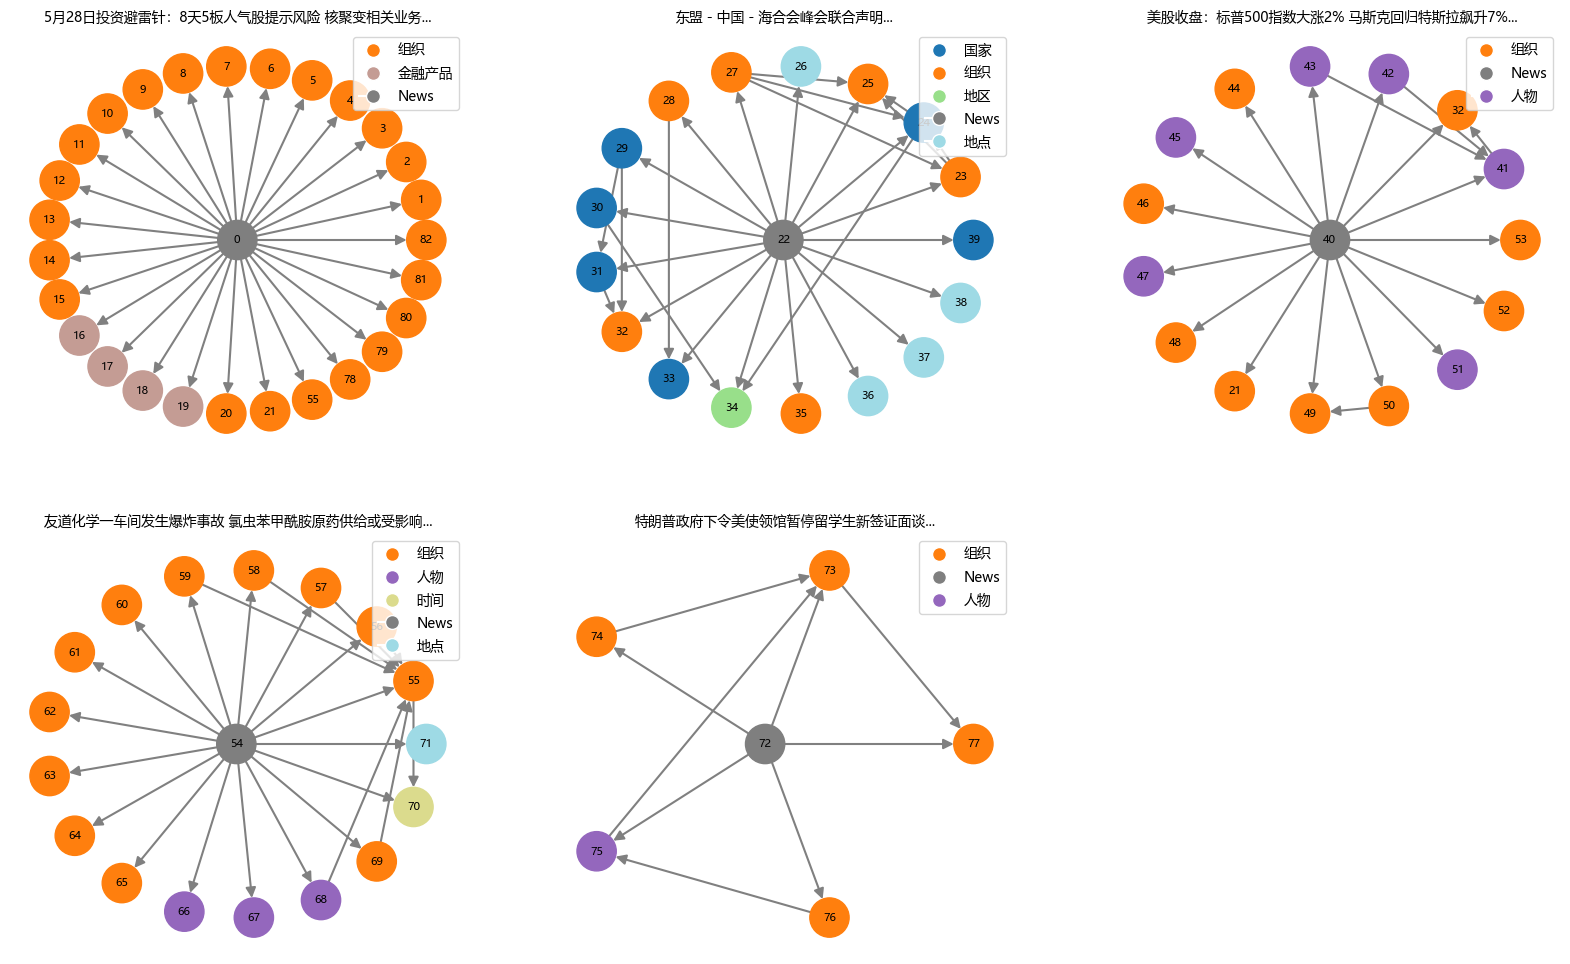

In [17]:
# 创建画布和子图布局
plt.figure(figsize=(20, 12))

# 找出所有新闻节点
news_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'News']

# 为每个新闻节点创建子图
max_subplots = 6  # 最多显示6个子图
for i, news_node in enumerate(news_nodes[:max_subplots]):
    ax = plt.subplot(2, 3, i+1) if len(news_nodes) <= 6 else plt.subplot(3, 3, i+1)
    
    # 获取该新闻连接的所有节点
    connected_nodes = [news_node] + list(G.successors(news_node))
    subgraph = G.subgraph(connected_nodes)
    
    # 设置布局（以新闻节点为中心）
    pos = {news_node: (0, 0)}  # 新闻节点在中心
    
    # 其他节点均匀分布在圆周上
    radius = 5
    angle = 2 * np.pi / max(1, len(connected_nodes)-1)
    for j, node in enumerate(connected_nodes[1:], 1):
        pos[node] = (radius * np.cos(j*angle), radius * np.sin(j*angle))
    
    # 绘制节点（根据类型着色）
    node_colors = [type_color_map[G.nodes[node]['type']] for node in subgraph.nodes()]
    
    nx.draw(subgraph, pos, ax=ax, with_labels=True, 
            node_color=node_colors, node_size=800,
            font_size=8, arrowsize=15, 
            edge_color='gray', width=1.5)
    
    # 设置标题
    title = G.nodes[news_node]['title'][:30] + '...' if G.nodes[news_node]['title'] else f"新闻节点{news_node}"
    ax.set_title(title, fontsize=10)
    
    # 添加图例（只显示当前子图中出现的类型）
    present_types = set(G.nodes[node]['type'] for node in connected_nodes)
    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                             label=t, markerfacecolor=type_color_map[t], 
                             markersize=10) for t in present_types]
    ax.legend(handles=legend_elements, loc='upper right')

# 如果新闻节点超过显示数量，添加提示
if len(news_nodes) > max_subplots:
    print(f"警告: 只显示了前{max_subplots}个新闻节点，共有{len(news_nodes)}个新闻节点")

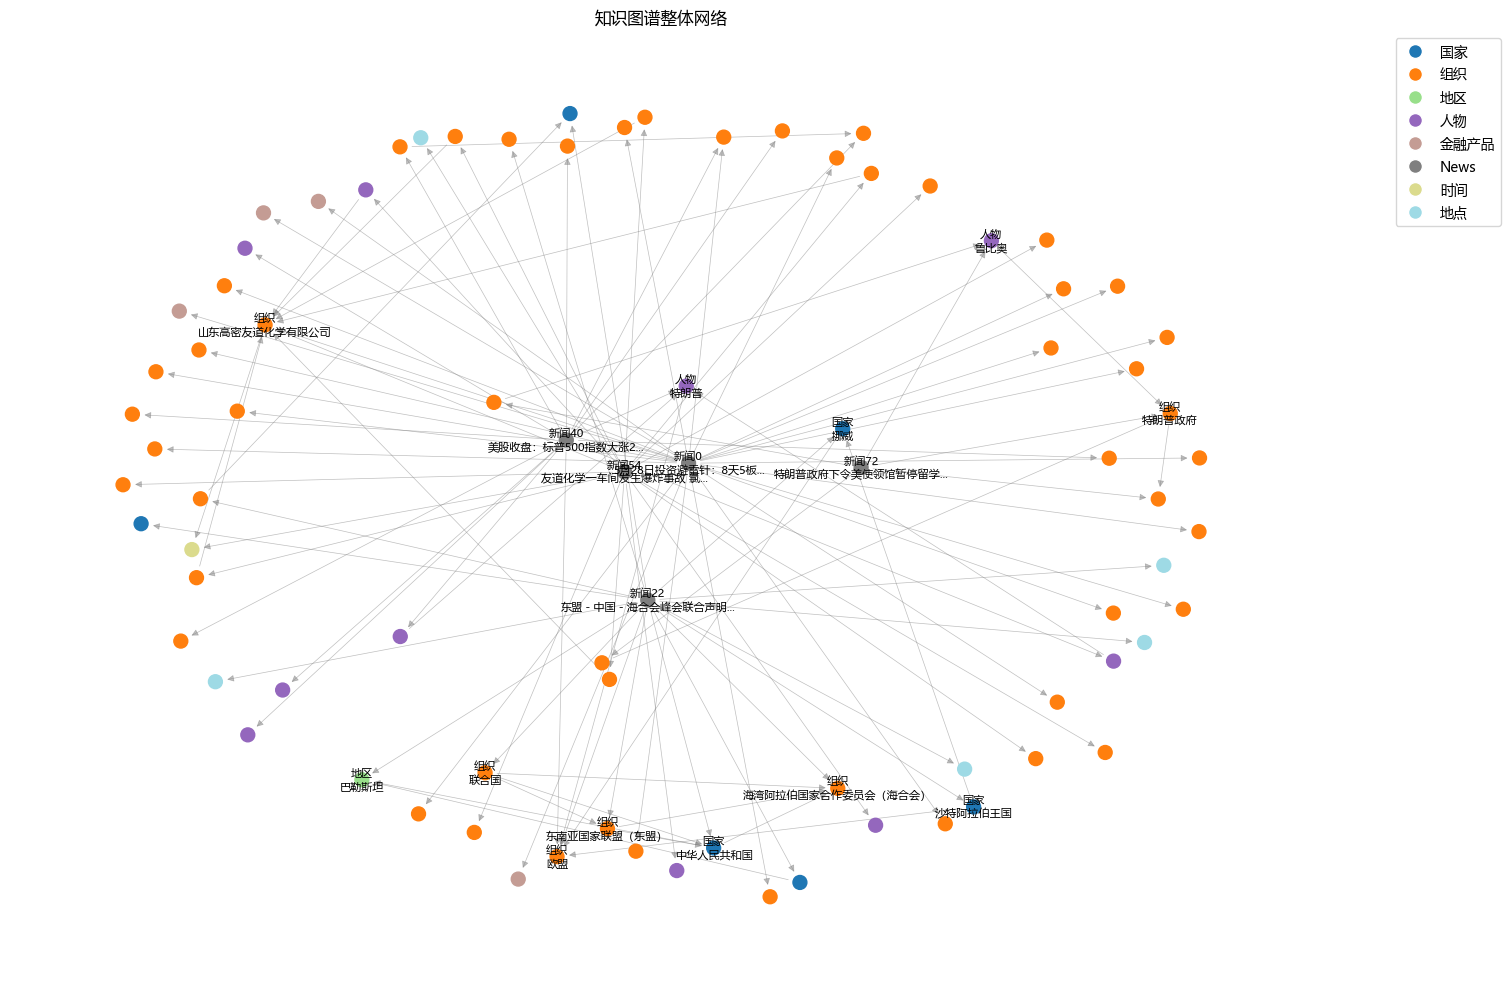

In [18]:
# 整体网络图（单独显示）
plt.figure(figsize=(15, 10))

# 使用spring布局
pos = nx.spring_layout(G, k=0.8, iterations=50)

# 绘制所有节点（按类型着色）
node_colors = [type_color_map[G.nodes[n]['type']] for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)

# 绘制边（透明度调低）
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5)

# 添加标签（只显示部分重要节点）
for node in G.nodes():
    if G.nodes[node]['type'] == 'News' or G.degree(node) > 2:  # 显示新闻节点和高连接度节点
        plt.text(pos[node][0], pos[node][1], G.nodes[node]['label'], 
                fontsize=8, ha='center', va='center')

# 添加图例
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                         label=t, markerfacecolor=type_color_map[t], 
                         markersize=10) for t in unique_types]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title("知识图谱整体网络", fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

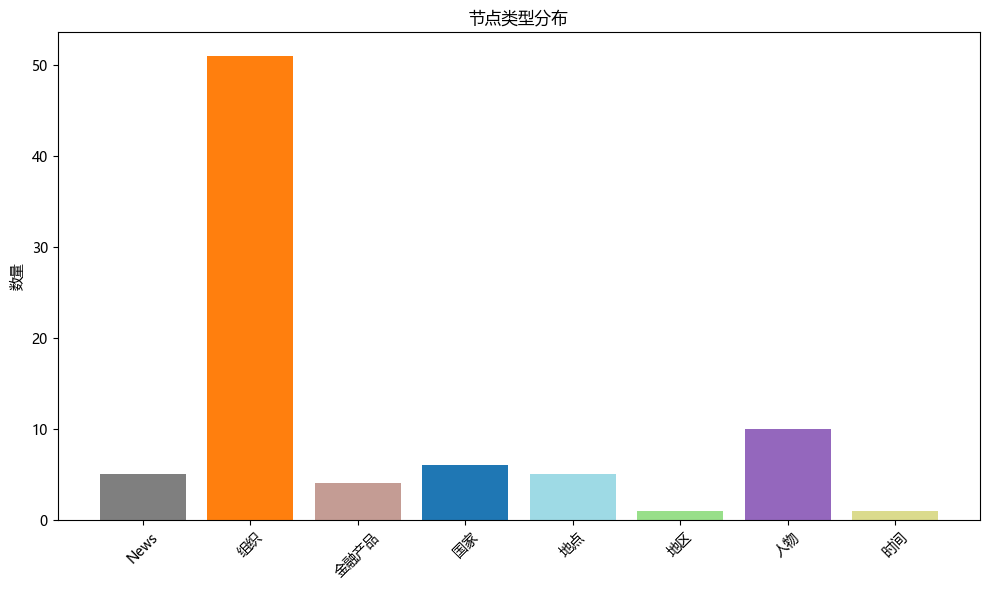

In [19]:
plt.figure(figsize=(10, 6))
type_counts = defaultdict(int)
for t in node_types:
    type_counts[t] += 1

plt.bar(type_counts.keys(), type_counts.values(), 
       color=[type_color_map[t] for t in type_counts.keys()])
plt.title("节点类型分布", fontsize=12)
plt.xticks(rotation=45)
plt.ylabel("数量")
plt.tight_layout()
plt.show()

In [20]:
# 1. 统一特征维度
max_len = max(len(feat) for feat in node_features)
print(f"最大特征维度: {max_len}")

# 填充短的特征向量（用0填充）
padded_features = []
for feat in node_features:
    if len(feat) < max_len:
        padded = feat + [0.0] * (max_len - len(feat))
    else:
        padded = feat
    padded_features.append(padded)

# 2. 转换为NumPy数组
node_features = np.array(padded_features, dtype=np.float32)
x = torch.tensor(node_features, dtype=torch.float)

# 3. 准备边索引
edge_index = torch.tensor(list(zip(*edges)), dtype=torch.long).contiguous()

# 4. 处理节点类型
type_encoder = LabelEncoder()
node_type_labels = type_encoder.fit_transform(node_types)
node_type_labels = torch.tensor(node_type_labels, dtype=torch.long)

# 5. 创建Data对象
data = Data(
    x=x,
    edge_index=edge_index,
    node_type=node_type_labels,
    num_nodes=len(nodes)
)

# 6. 验证
print("\nPyG Data对象信息:")
print(data)
print(f"\n节点特征维度: {data.x.shape}")
print(f"边索引维度: {data.edge_index.shape}")
print(f"节点类型维度: {data.node_type.shape}")

最大特征维度: 70

PyG Data对象信息:
Data(x=[83, 70], edge_index=[2, 108], node_type=[83], num_nodes=83)

节点特征维度: torch.Size([83, 70])
边索引维度: torch.Size([2, 108])
节点类型维度: torch.Size([83])


In [21]:
# 创建特征说明列表
feature_descriptions = [
    "内容长度",
    *[f"属性存在({key})" for key in all_attribute_keys]
]

# 打印带说明的特征
print("\n带说明的节点特征:")
for node_id, (node, features) in enumerate(zip(nodes, node_features)):
    print(f"\n节点ID {node_id} ({node['type']}): {node.get('name', '无名称')}")
    for desc, val in zip(feature_descriptions, features):
        print(f"{desc}: {val}")
    if node_id >= 4:  # 限制打印数量
        print("\n...（更多节点省略）")
        break


带说明的节点特征:

节点ID 0 (News): 
内容长度: 1403.0
属性存在(action): 0.0
属性存在(content): 0.0
属性存在(date): 1.0
属性存在(dates): 0.0
属性存在(event): 0.0
属性存在(events): 0.0
属性存在(initiative): 0.0
属性存在(initiatives): 0.0
属性存在(location): 0.0
属性存在(name): 0.0
属性存在(role): 0.0
属性存在(status): 0.0
属性存在(title): 0.0
属性存在(url): 1.0
属性存在(主要产品): 1.0
属性存在(事件): 0.0
属性存在(代表): 0.0
属性存在(价格): 0.0
属性存在(伤亡): 0.0
属性存在(位置): 0.0
属性存在(全球地位): 0.0
属性存在(公告): 0.0
属性存在(关系): 0.0
属性存在(原因): 0.0
属性存在(发布数据): 0.0
属性存在(变化): 0.0
属性存在(名称): 0.0
属性存在(国籍): 0.0
属性存在(姓名): 0.0
属性存在(官方语言): 0.0
属性存在(工作服): 0.0
属性存在(工厂位置): 0.0
属性存在(年产能): 0.0
属性存在(影响): 0.0
属性存在(成立时间): 0.0
属性存在(所属国家): 0.0
属性存在(报道内容): 0.0
属性存在(报道时间): 0.0
属性存在(控股公司): 0.0
属性存在(日期): 0.0
属性存在(时间点): 0.0
属性存在(生产状态): 0.0
属性存在(目标): 0.0
属性存在(第一季度营收): 0.0
属性存在(类型): 0.0
属性存在(职业): 0.0
属性存在(职位): 0.0
属性存在(职责): 0.0
属性存在(股东减持): 0.0
属性存在(股价变动): 0.0
属性存在(股价变化): 0.0
属性存在(股票代码): 0.0
属性存在(行动): 0.0
属性存在(被针对原因): 0.0
属性存在(观点): 0.0
属性存在(计划): 0.0
属性存在(计划产能): 0.0
属性存在(记者): 0.0
属性存在(访问限制): 0.0
属性存在(评论): 0.0
属性存在(诉讼): 0.0
属性存在(